In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
data = pd.read_csv('train-2.csv')

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [5]:
msk = np.random.rand(len(data)) < 0.7
train = data[msk]
test = data[~msk]

In [22]:
# labels, feature
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
y_test = test[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [7]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)  # train --> vocabulary
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [8]:
#commented it due to long output
#for occurence of words
#tokenizer.word_counts
#for index of words
#tokenizer.word_index

In [9]:
list_tokenized_train[:1] #Keras has turned our words into index representation for us

[[437,
  443,
  73,
  133,
  14,
  249,
  2,
  71,
  314,
  77,
  50,
  9,
  13,
  622,
  8,
  2321,
  482,
  505,
  101,
  4,
  607,
  2,
  36,
  326,
  123,
  359,
  3,
  29,
  38,
  28,
  52,
  209,
  2,
  420,
  57,
  35,
  1,
  2398,
  93,
  1,
  722,
  471]]

we have to feed a stream of data that has a consistent length(fixed number of features)

In [10]:
# padding the words: fill the shorter one, trim the longer one， pre pad is default
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

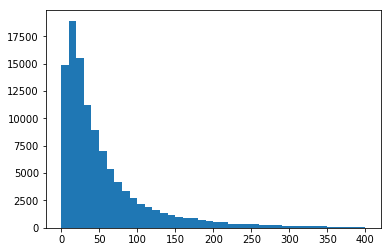

In [11]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

Building the model

In [12]:
inp = Input(shape=(maxlen, ))

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence.

In [13]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [14]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

In [15]:
x = GlobalMaxPool1D()(x)

In [16]:
x = Dropout(0.1)(x)

In [17]:
x = Dense(50, activation="relu")(x)

In [18]:
x = Dropout(0.1)(x)

In [19]:
x = Dense(6, activation="sigmoid")(x)

In [20]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Put the data into model

In [21]:
batch_size = 256
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 100162 samples, validate on 11130 samples
Epoch 1/2
100162/100162 [==============================] - 142s 1ms/step - loss: 0.1621 - acc: 0.9618 - val_loss: 0.0887 - val_acc: 0.9650
Epoch 2/2
100162/100162 [==============================] - 124s 1ms/step - loss: 0.0601 - acc: 0.9787 - val_loss: 0.0548 - val_acc: 0.9802


In [24]:
batch_size = 256
model.evaluate(X_te,y_test, batch_size=batch_size)

48279/48279 [==============================] - 15s 309us/step


[0.04990057219165927, 0.9821212753428523]